In [29]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

import xgboost as xgb

import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [30]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

In [31]:
X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

Y_train_observed_a = pd.read_parquet('../A/train_targets.parquet')
Y_train_observed_b = pd.read_parquet('../B/train_targets.parquet')
Y_train_observed_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

In [32]:
X_train_observed_a.describe()

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
count,118669,118669.000000,118669.000000,96422.000000,1.186690e+05,118669.000000,110603.000000,118669.000000,118669.000000,118669.000000,1.186690e+05,118669.000000,1.186690e+05,118669.000000,118669.0,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,2724.0,118669.000000,118669.0,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000,118669.000000
mean,2021-02-09 23:30:00,6.652576,1.249064,2907.949219,5.994018e+05,166.500381,1737.142212,0.022398,276.823395,44.918282,1.617057e+05,56.611744,2.038025e+05,67.605507,6.0,0.053117,0.004418,0.106243,0.013277,0.026567,0.521391,0.511650,1009.632996,0.006302,0.091018,996.765381,1002.868225,0.187399,0.011914,74.231705,1008.998352,250.0,0.052763,0.0,0.000062,0.091566,179.629486,1.529545,0.059087,280.708557,74.401077,32446.992188,3.043197,0.756781,0.517437,0.000019
min,2019-06-02 22:00:00,0.700000,1.145000,27.799999,0.000000e+00,0.000000,27.900000,-1.000000,250.899994,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,944.299988,0.000000,0.000000,932.299988,938.099976,0.000000,0.000000,22.700001,943.900024,250.0,0.000000,0.0,-0.000000,0.000000,0.002000,-50.004002,0.000000,258.899994,0.000000,154.300003,0.000000,-7.300000,-9.300000,-0.000000
25%,2020-04-06 22:45:00,4.400000,1.224000,1102.900024,0.000000e+00,0.000000,590.700012,0.000000,272.100006,0.000000,0.000000e+00,0.000000,0.000000e+00,43.299999,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1002.099976,0.000000,0.000000,989.299988,995.299988,0.000000,0.000000,65.000000,1001.400024,250.0,0.000000,0.0,0.000000,0.000000,88.487999,-15.066000,0.000000,275.899994,54.799999,15592.400391,1.700000,-1.400000,-0.700000,0.000000
50%,2021-02-09 23:30:00,6.300000,1.247000,1882.400024,3.574770e+04,8.600000,1162.599976,0.000000,277.200012,4.100000,2.481410e+04,0.000000,8.960000e+01,80.500000,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1010.700012,0.000000,0.000000,997.900024,1003.900024,0.000000,0.000000,76.699997,1010.000000,250.0,0.000000,0.0,0.000000,0.000000,179.436996,1.202000,0.000000,280.700012,93.699997,36359.800781,2.700000,0.400000,0.500000,0.000000
75%,2021-12-16 00:15:00,8.600000,1.272000,3969.750000,1.037819e+06,288.799988,2079.600098,0.000000,282.000000,76.000000,2.743256e+05,41.799999,1.598314e+05,98.800003,6.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1018.299988,0.000000,0.000000,1005.400024,1011.500000,0.000000,0.000000,85.400002,1017.599976,250.0,0.000000,0.0,0.000000,0.100000,270.640991,18.995001,0.100000,285.200012,99.900002,48084.500000,4.100000,2.700000,1.700000,0.000000
max,2022-10-21 01:00:00,17.500000,1.427000,12328.500000,3.005720e+06,836.400024,11688.700195,1.000000,293.799988,345.700012,1.205498e+06,688.700012,2.451173e+06,100.000000,6.0,15.100000,3.900000,15.100000,7.900000,14.800000,1.000000,1.000000,1044.000000,2.230000,6.000000,1

In [33]:
X_train_concat = pd.concat([X_train_observed_a, X_train_estimated_a], ignore_index=True)

In [34]:
X_train_group = X_train_concat.groupby(pd.Grouper(key='date_forecast', freq='1H')).mean().reset_index()
X_train_group.rename(columns={"date_forecast":"time"}, inplace=True)

In [35]:
X_train_group.tail()

,time,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc
34269,2023-04-30 19:00:00,4.55,1.27650,1674.199951,84464.945312,4.225,542.700012,0.0,272.424988,2.825,56431.050781,0.1,13230.649414,96.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.5,0.75,1014.750000,0.0,0.0,1001.574951,1007.799988,0.0,0.0,74.625000,1014.049988,NaN,0.0,0.0,0.0,0.000,304.939240,-0.18050,0.000,275.024994,96.699997,23417.074219,5.175,4.800,1.925,0.0,2023-04-29 07:00:05
34270,2023-04-30 20:00:00,4.50,1.27975,1762.400024,2270.875000,0.000,546.400024,0.0,272.299988,0.000,5067.875000,0.0,176.350006,94.224998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.700012,0.0,0.0,1001.549988,1007.799988,0.0,0.0,76.875000,1014.049988,NaN,0.0,0.0,0.0,0.000,318.625763,-5.17600,0.000,274.650024,94.525002,21084.050781,4.650,4.025,2.300,0.0,2023-04-29 07:00:05
34271,2023-04-30 21:00:00,4.50,1.28100,1696.650024,0.000000,0.000,548.349976,0.0,272.299988,0.000,0.000000,0.0,0.000000,94.324997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.549988,0.0,0.0,1001.400024,1007.674988,0.0,0.0,77.775002,1013.925049,NaN,0.0,0.0,0.0,0.000,332.785736,-8.95075,0.000,274.524994,95.675003,20792.500000,4.450,3.575,2.600,0.0,2023-04-29 07:00:05
34272,2023-04-30 22:00:00,4.50,1.28100,1353.400024,0.000000,0.000,527.775024,0.0,272.299988,0.000,0.000000,0.0,0.000000,97.775002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.400024,0.0,0.0,1001.250000,1007.500000,0.0,0.0,79.000000,1013.799988,NaN,0.0,0.0,0.0,0.025,347.377991,-11.23325,0.100,274.325012,98.875000,14158.099609,4.100,3.175,2.550,0.0,2023-04-29 07:00:05
34273,2023-04-30 23:00:00,4.50,1.28100,1626.574951,0.000000,0.000,526.525024,0.0,272.274994,0.000,0.000000,0.0,0.000000,98.425003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00,1014.049988,0.0,0.0,1000.875000,1007.099976,0.0,0.0,79.849998,1013.400024,NaN,0.0,0.0,0.0,0.050,92.209503,-11.84150,0.075,274.225006,99.699997,11872.299805,3.750,2.725,2.550,0.0,2023-04-29 07:00:05


In [36]:
inner_merge = pd.merge(X_train_group, Y_train_observed_a, on="time", how="inner")

In [37]:
inner_merge.head()

,time,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,date_calc,pv_measurement
0,2019-06-02 22:00:00,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.074997,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1006.299988,0.0,0.0,993.750000,999.775024,0.0,0.000,71.674995,1005.799988,NaN,0.0,0.0,0.0,0.175,348.036743,-3.77425,0.0,286.225006,100.000000,40386.476562,3.600,-3.575,-0.500,0.0,NaT,0.00
1,2019-06-02 23:00:00,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,0.00,0.000000,99.750000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1005.200012,0.0,0.0,992.674988,998.650024,0.0,0.025,68.000000,1004.650024,NaN,0.0,0.0,0.0,0.200,91.980751,-4.35725,0.0,286.899994,100.000000,33770.648438,3.350,-3.350,0.275,0.0,NaT,0.00
2,2019-06-03 00:00:00,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1004.525024,0.0,0.0,992.000000,997.974976,0.0,0.100,67.949997,1003.950012,NaN,0.0,0.0,0.0,0.400,14.934750,-3.30950,0.0,286.950012,100.000000,13595.500000,3.050,-2.950,0.750,0.0,NaT,0.00
3,2019-06-03 01:00:00,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,0.00,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.25,1.0,1004.025024,0.0,0.0,991.500000,997.449951,0.0,0.125,73.875000,1003.449951,NaN,0.0,0.0,0.0,0.550,28.630251,-0.82250,0.0,286.750000,100.000000,2321.850098,2.725,-2.600,0.875,0.0,NaT,0.00
4,2019-06-03 02:00:00,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,0.15,282.975006,84.875000,6.0,0.0,0.0,0.0,0.0,0.0,1.00,0.0,1003.099976,0.0,0.0,990.550049,996.500000,0.0,0.100,79.925003,1002.500000,NaN,0.0,0.0,0.0,0.250,41.997501,3.05125,0.0,286.450012,99.224998,11634.799805,2.550,-2.350,0.925,0.0,NaT,19.36


In [38]:
inner_to_split = inner_merge.copy().drop(columns=["time", "date_calc"])
id_columns = [c for c in inner_to_split.columns if ":idx" in c]
non_id_columns = [c for c in inner_to_split.columns if ":id" not in c and "date" not in c]

inner_to_split[id_columns] = inner_to_split[id_columns].astype("category")
inner_to_split[non_id_columns] = inner_to_split[non_id_columns].astype("float")

X = inner_to_split[[c for c in inner_to_split.columns if c != "pv_measurement"]]
Y = inner_to_split[[c for c in inner_to_split.columns if c == "pv_measurement"]].astype(int)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=10, test_size=0.25)

In [40]:
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:463: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  or is_sparse(dtype)
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:464: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  or (is_categorical_dtype(dtype) and enable_categorical)
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isins

In [41]:
# params = {'max_depth':2, 'eta':1, 'silent':1, "objective": "reg:squarederror", "tree_method": "gpu_hist"}
params = {"objective": "reg:squarederror", "tree_method": "auto"}
n = 5000

evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=250,
   early_stopping_rounds=50
)

[0]	validation-rmse:864.96207	train-rmse:884.41906
[250]	validation-rmse:413.56477	train-rmse:91.23660
[500]	validation-rmse:413.39657	train-rmse:36.87866
[750]	validation-rmse:413.64313	train-rmse:17.53056
[1000]	validation-rmse:413.59950	train-rmse:9.61985
[1250]	validation-rmse:413.48316	train-rmse:5.66962
[1500]	validation-rmse:413.48317	train-rmse:3.53601
[1750]	validation-rmse:413.48979	train-rmse:2.34991
[2000]	validation-rmse:413.47065	train-rmse:1.66846
[2250]	validation-rmse:413.46723	train-rmse:1.28960
[2500]	validation-rmse:413.47080	train-rmse:1.09031
[2750]	validation-rmse:413.47023	train-rmse:0.99408
[3000]	validation-rmse:413.47023	train-rmse:0.95074
[3250]	validation-rmse:413.47012	train-rmse:0.93151
[3500]	validation-rmse:413.46999	train-rmse:0.92352
[3750]	validation-rmse:413.46890	train-rmse:0.91979
[4000]	validation-rmse:413.46897	train-rmse:0.91824
[4250]	validation-rmse:413.46873	train-rmse:0.91753
[4500]	validation-rmse:413.46859	train-rmse:0.91721
[4750]	valida

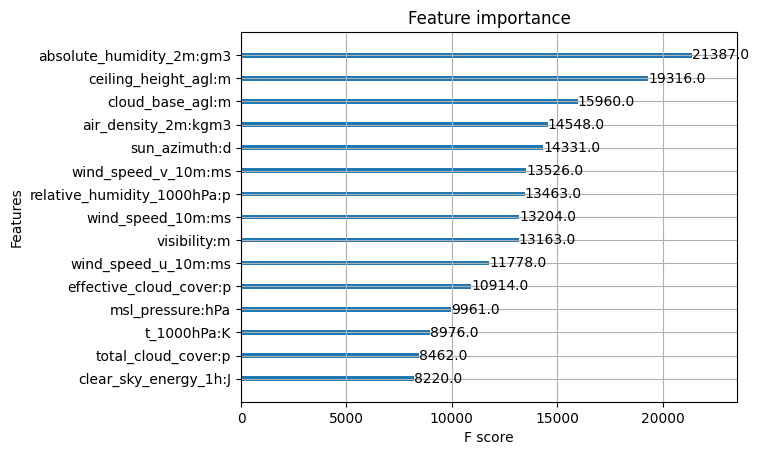

In [42]:
xgb.plot_importance(model,max_num_features=15)
plt.show()

In [43]:
preds = model.predict(dtest_reg)

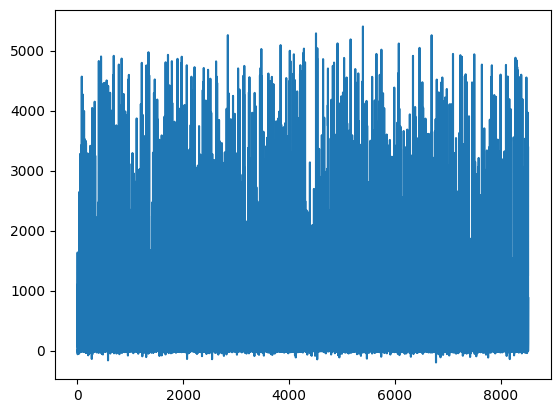

In [44]:
plt.plot(preds)

In [45]:
rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 413.469


# Tuning

In [46]:
label_encoder = LabelEncoder()
sc = StandardScaler()
y_train = label_encoder.fit_transform(y_train)

/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [47]:
len(X_train), len(y_train)

(25563, 25563)

In [48]:
def auc(m, train, test): 
    return (roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            roc_auc_score(y_test,m.predict_proba(test)[:,1]))

# Parameter Tuning
xgb_classifier = xgb.XGBClassifier()

param_dist = {"max_depth": [10,30,50],
              "min_child_weight" : [1,3,6],
              "n_estimators": [200],
              "learning_rate": [0.05, 0.1,0.16],}

grid_search = GridSearchCV(xgb_classifier, 
                           param_grid=param_dist, 
                           cv = 5, 
                           verbose=10, 
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

model = xgb.XGBClassifier(max_depth=50, min_child_weight=1,  n_estimators=200,\
                          n_jobs=-1 , verbose=1,learning_rate=0.16)

# model = grid_search.best_estimator_

model.fit(X_train,y_train)

auc(model, X_train, y_test)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[CV 5/5; 1/27] START learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200
[CV 4/5; 1/27] START learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200
[CV 5/5; 1/27] END learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5; 1/27] START learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200
[CV 4/5; 1/27] END learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200;, score=nan total time=   0.0s
[CV 3/5; 1/27] START learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200
[CV 2/5; 2/27] START learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200
[CV 2/5; 1/27] END learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators=200;, score=nan total time=   0.0s
[CV 1/5; 2/27] START learning_rate=0.05, max_depth=10, min_child_weight=3, n_estimators=200
[CV 3/5; 1/27] END learning_rate=0.05, max_depth=10, min_child_weight=1, n_estimators

ValueError: 
All the 135 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3534 3535 3536], got [   0    1    2 ... 3844 3845 3847]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3547 3548 3549], got [   0    1    2 ... 3845 3846 3847]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3560 3561 3562], got [   0    1    2 ... 3844 3845 3846]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3558 3559 3560], got [   0    1    2 ... 3845 3846 3847]

--------------------------------------------------------------------------------
27 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/miksx/.pyenv/versions/3.11.4/envs/TDT4173/lib/python3.11/site-packages/xgboost/sklearn.py", line 1467, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [   0    1    2 ... 3547 3548 3549], got [   0    1    2 ... 3844 3846 3847]
